# Trabalho Prático nº 1 - Análise de Expressões Faciais em Vídeo
## Tópicos de Ciência dos Dados - MECD (2023/2024)

- Carlos Matos - 2020245868
- Mariana Magueijo - 2020246886

In [72]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np
import random
from scipy.spatial import distance
from scipy.stats import ks_2samp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

##### Funções auxiliares

In [ ]:
number_emotions = {'01': 'Neutral', '02': 'Calm', '03': 'Happy', '04': 'Sad', '05': 'Angry', '06': 'Fearful', '07': 'Disgust', '08': 'Surprised'}

In [ ]:
def one_file_coordinates(file):
    landmark = 68
    f = pd.read_csv("dataset/" + file)
    frame_dict = {}
    for nl in range(f.shape[0]):
        if pd.isna(f["frame"][nl]):
            break
        for i in range(landmark):
            
            if nl in frame_dict:
                frame_dict[nl].append([f["x_" + str(i)][nl], f["y_" + str(i)][nl]])
            else:
                frame_dict[nl] = [[f["x_" + str(i)][nl], f["y_" + str(i)][nl]]]
    return frame_dict

In [ ]:
def file_coordinates(path):
    files = os.listdir(path)
    landmark = 68
    all_info = {}
    for file in files:
        f = pd.read_csv("dataset/" + file)
        frame_dict = {}
        for nl in range(f.shape[0]):
            if pd.isna(f["frame"][nl]):
                break
            for i in range(landmark):
                
                if nl in frame_dict:
                    frame_dict[nl].append([f["x_" + str(i)][nl], f["y_" + str(i)][nl]])
                else:
                    frame_dict[nl] = [[f["x_" + str(i)][nl], f["y_" + str(i)][nl]]]
        all_info[file] = frame_dict
    with open("dicionary_inicial.pkl", 'wb') as arq:
        pickle.dump(all_info, arq)

    return all_info

if os.path.exists("dicionary_inicial.pkl"):
    with open("dicionary_inicial.pkl", 'rb') as arq:
        all_d = pickle.load(arq)
else:
    all_d = file_coordinates("dataset/")

print(all_d)

#### 2. Extração do conteúdo dos ficheiros do dataset
##### 2.1 Tratamento do dataset para um dicionário

In [ ]:
def read_files(path):
    files = os.listdir(path)
    subject_emotions= {}

    for file in files:
        divide = file.split('-')
        last = divide[-1]
        name = os.path.splitext(last)[0]
        divide[-1] = name

        actor = "Actor " + str(int(name))

        if actor in subject_emotions:
            emotion = number_emotions[divide[2]]
            if emotion in subject_emotions[actor]:
                subject_emotions[actor][emotion].append(file)
            else:
                subject_emotions[actor][emotion] = [file]
        else:
            subject_emotions[actor] = {number_emotions[divide[2]]: [file]} 

    return subject_emotions
        
all_subject_emotions = read_files("dataset")
print(all_subject_emotions)


##### 2.2 Coordenadas e preenchimento a NaN

In [ ]:
def subject_routine(subject_emotions):
    subject_data = {}
    landmarks = 68 * 2
    max_frames = 0
    for subject in subject_emotions:
        actor = subject
        count_files = 0
        for emotion in subject_emotions[subject]:
            count_files += len(subject_emotions[subject][emotion])
            for file in subject_emotions[subject][emotion]:
                string = "dataset/" + file
                nl = (pd.read_csv(string)).shape[0]
                if nl > max_frames:
                    max_frames = nl
        subject_data[actor] = [count_files, landmarks]
    for subject in subject_data:
        subject_data[subject].append(max_frames)

    return subject_data, max_frames

all_subject_data, all_max_frames = subject_routine(all_subject_emotions)


In [ ]:
def complete_files(path, max_frames):
    files = os.listdir(path)

    for file in files:
        string = "dataset/" + file
        f = pd.read_csv(string)
        nl = f.shape[0]
        add_lines = max_frames - nl
        if add_lines > 0:
            nan_lines = [None for _ in range(add_lines)]
            new_file = pd.concat([f, pd.DataFrame(nan_lines)], ignore_index=True)
            new_file.to_csv(string, index=False)

if len(pd.read_csv("dataset/01-01-01-01-01-01-01.csv")) != all_max_frames:
    complete_files("dataset", all_max_frames)

##### 2.3 Emoção - Nome do Ficheiro

In [ ]:
def emotion_file(subject_emotions):
    ef = []
    
    for key1, value1 in subject_emotions.items():
        for key2, value2 in value1.items():
            ef.extend([key2, emotion] for emotion in value2)
    
    return ef

ef = emotion_file(all_subject_emotions)
print(ef)

##### 2.4 e 2.5 Representação dos frames em imagem

In [ ]:
def show_expression(d, file, frames):
    matrix_x = []
    matrix_y = []
    for frame in range(frames):
        for coordinates in d[file][frame]:
            matrix_x.append(coordinates[0])
            matrix_y.append(coordinates[1])
        plt.scatter(matrix_x, np.multiply(matrix_y, -1))
        plt.axis('off')
    plt.show()
    
all_frames = 5
if all_frames > all_max_frames:
    frames = all_max_frames

show_expression(all_d, '01-01-01-01-01-01-01.csv', all_frames)

#### 3. Análise e tratamento de Outliers
##### 3.1 Normalização das coordenadas

In [ ]:
def nomalize_coordinates(d, x_max, y_max, ref):    
    for file in d.keys():
        for frame in d[file]:
            x_ref = d[file][frame][ref][0]
            y_ref = d[file][frame][ref][1]
            for coordenates in d[file][frame]:
                coordenates[0] =  (coordenates[0] - x_ref) / x_max
                coordenates[1] =  (coordenates[1] - y_ref) / y_max
    
    with open("dicionary_normalized.pkl", 'wb') as arq:
        pickle.dump(d, arq)
    return d 

if os.path.exists("dicionary_normalized.pkl"):
    with open("dicionary_normalized.pkl", 'rb') as arq:
        all_d_normalized = pickle.load(arq)
else:
    all_d_normalized = nomalize_coordinates(d, 1280, 720, 27)
    
print(all_d_normalized)

##### 3.2 Boxplot

In [ ]:
def boxplot(d_normalized, coordinate, landmark, plot):
    emotions = {"01" : [], "02" : [], "03" : [], "04" : [], "05": [], "06" : [], "07" : [], "08" : []}
    x_labels = np.array(['Neutral', 'Calm', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgust', 'Surprised'])
    for file in d_normalized.keys():
        em = file.split('-')[2]
        value = 0
        for frame in d_normalized[file]:
            value += d_normalized[file][frame][landmark][coordinate]
        emotions[em].append(value/len(d_normalized[file]))
    data = [emotions["01"], emotions["02"], emotions["03"], emotions["04"], emotions["05"], emotions["06"], emotions["07"], emotions["08"]] 
    if plot:
        plt.boxplot(data, vert=True, labels=x_labels) #orientaçao vertical
        plt.show()
              
    return emotions    

all_d_boxplot = boxplot(all_d_normalized, 0, 54, False)

    

##### 3.3 Densidade dos Outliers

In [ ]:
def density_outliers(data):
    data.sort()
    num_data = len(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)

    iqr = q3 - q1
    lim_superior = q3 + 1.5 * iqr
    lim_inferior = q1 - 1.5 * iqr

    outliers = [x for x in data if x > lim_superior or x < lim_inferior]
    num_outliers = len(outliers)

    density = (num_outliers/num_data) * 100
    return density, outliers


In [ ]:
def total_densities(d_normalized):
    densities = []
    for coordinate in range(2):
        for i in range(68):
            emotions = boxplot(d_normalized, coordinate, i, False)
            for em in emotions:
                densities.append(density_outliers(emotions[em])[0])
    
    return np.mean(densities), np.std(densities)

all_density_mean, all_density_std = total_densities(all_d_normalized)

print("Densidade de outliers no dataset: ")
print("Média: " + str(all_density_mean))
print("Desvio padrão: " + str(all_density_std))

##### 3.4 Desidade de Outliers usando Z-Score

In [ ]:
def zscore_outliers(array, k):
    mean = np.mean(array)
    std = np.std(array)
    outliers = []
    for x in range(len(array)):
        z = abs((array[x] - mean)/std)
        if z >= k:
            outliers.append(x)
    return outliers

##### 3.5 Mostra a expressão com outliers a vermelho

In [ ]:
def expression_outliers_zscore(d_normalized, file, frames, k):
    for frame in range(frames):
        matrix_x = []
        matrix_y = []
        for coordinates in d_normalized[file][frame]:
            matrix_x.append(coordinates[0])
            matrix_y.append(coordinates[1])

        matrix_x = np.array(matrix_x)
        matrix_y = np.array(matrix_y)
        outliers_x = zscore_outliers(matrix_x, k)
        outliers_y = zscore_outliers(matrix_y, k)

        len_img = max(matrix_y)
        matrix_y = len_img - matrix_y
        plt.scatter(matrix_x, matrix_y, c = 'black')
        plt.scatter(matrix_x[outliers_x], matrix_y[outliers_x], c = 'red')
        plt.scatter(matrix_x[outliers_y], matrix_y[outliers_y], c = 'red')
        plt.axis('off')
        plt.show()

expression_outliers_zscore(all_d_normalized, '01-01-02-01-01-01-01.csv', 1, 2)

##### 3.7 Algoritmo k-means

In [ ]:
def cluster_groups(all_coordenates, centroids):
    group_centroids = {}
    for i in range(len(centroids)):
        group_centroids[i] = []

    for coordenate in all_coordenates:
        aux = []
        for centroid in centroids:
            aux.append(distance.euclidean(centroid, coordenate))
        i = aux.index(min(aux))
        group_centroids[i].append(coordenate)
    return group_centroids

In [ ]:
def algorithm_kmeans(d_normalized, file, frame, number_clusters):
    all_coordenates = d_normalized[file][frame]

    centroids = []
    for i in range(number_clusters):    
        c = random.choice(all_coordenates)
        if c not in centroids:
            centroids.append(c)
        else:
            i -= 1
    group = cluster_groups(all_coordenates, centroids)

    while(1):
        new_centroids = []
        for i in range(len(centroids)):
            new_centroids.append([np.mean([coord[0] for coord in group[i]]), np.mean([coord[1] for coord in group[i]])])
        new_group = cluster_groups(all_coordenates, centroids)
        if new_group == group:
            break
        else:
            group = new_group
            centroids = new_centroids
    
    return group, centroids


all_file_kmeans = '01-01-02-01-01-01-01.csv'
all_frame_kmeans = 0
all_number_cluster = 2

all_group_centroids, all_centroids = algorithm_kmeans(all_d_normalized, all_file_kmeans, all_frame_kmeans, all_number_cluster)

print(str(all_number_cluster) + " clusters com o algoritmo kmeans")
for i in range(all_number_cluster):
    print(all_centroids[i])
    print(all_group_centroids[i])
    print("--")
    

##### 3.8 Calcular os Outiliers através do k-means

In [ ]:
def kmeans_outliers(group_centroids, centroids):
    outliers = []
    for group in group_centroids:
        aux = []
        for coordenates in group_centroids[group]:
            aux.append(distance.euclidean(centroids[group], coordenates))
        mean_group = np.mean(aux)
        for dist in aux:
            if dist > mean_group:
                outliers.append(group_centroids[group][aux.index(dist)])
    return outliers 

all_outliers_kmeans = kmeans_outliers(all_group_centroids, all_centroids)  
print("Outliers com o algoritmo kmeans:") 
print(all_outliers_kmeans)    

In [ ]:
def expression_outliers_kmeans(outliers, d_normalized, file, frame):
    matrix_x = []
    matrix_y = []
    for coordinates in d_normalized[file][frame]:
        matrix_x.append(coordinates[0])
        matrix_y.append(coordinates[1])

    matrix_x = np.array(matrix_x)
    matrix_y = np.array(matrix_y)
    outliers = np.array(outliers)

    len_img = max(matrix_y)
    matrix_y = len_img - matrix_y
    plt.scatter(matrix_x, matrix_y, c = 'black')
    plt.scatter(outliers[ :, 0], len_img - outliers[ :, 1], c = 'red')

    plt.axis('off')
    plt.show()

    


expression_outliers_kmeans(all_outliers_kmeans, all_d_normalized, all_file_kmeans, all_frame_kmeans)

##### 3.9 Injetar Outliers num array

In [ ]:
def inject_outliers(array, x): 
    mean_array = np.mean(array)
    std_array = np.std(array)
    
    density, outliers = density_outliers(array)
    total_ind = []
    while density < x:
        not_outliers = []
        for i in array:
            if i not in outliers:
                not_outliers.append(i)
        numbers = int((x - density) * len(not_outliers))
        random_points = []
        ind = []
        for j in range(numbers):    
            c = random.choice(not_outliers)
            if c not in random_points:
                ind.append(array.index(c))
                total_ind.append(array.index(c))
                k = 1.5
                s = -1 + (random.random() * 2)
                q1 = np.percentile(array, 25)
                q3 = np.percentile(array, 75)
                iqr = q3 - q1
                z = q3 +  k * iqr
                q = random.random() * z
                p = mean_array + s * k * std_array + q
                c += p
                random_points.append(c)
            else:
                j -= 1
        for k in range(len(ind)):
            array[ind[k]] = random_points[k]
        density,outliers = density_outliers(array)    
    return array, total_ind      

##### 3.10 Determinar o modelo linear

In [ ]:
def linear_model(x, y):
    x = np.insert(x, 0, 1, axis=1)
    x_transpose = np.transpose(x)
    x_transpose_x = np.dot(x_transpose, x) #4 * 4
    x_transpose_x_inverse = np.linalg.inv(x_transpose_x)
    x_transpose_x_inverse_x = np.dot(x_transpose_x_inverse, x_transpose)
    beta = np.dot(x_transpose_x_inverse_x, y)
    return beta

##### 3.11 Usar 3.9 e 3.10 para um dado landmark

##### 4. Extração de informação estatística

##### 4.1 Features relevantes

In [ ]:
all_d_file = one_file_coordinates('01-01-01-01-01-01-01.csv')

all_landmarks = [22, 57, 66, 54, 45, 44, 47, 13, 33, 28]

In [ ]:
def just_landmarks(d):
    d_landmarks = {}
    for i in all_landmarks:
        for frame in d:
            if i not in d_landmarks:
                d_landmarks[i] = [[d[frame][i][0], d[frame][i][1]]]
            else:
                d_landmarks[i].append([d[frame][i][0], d[frame][i][1]])
    return d_landmarks

all_d_landmarks = just_landmarks(all_d_file)
print(all_d_landmarks)


4.1.1 Média dos landmarks selecionados

In [ ]:
def mean_landmarks():
    d_mean = {}
    for landmark in all_landmarks:
        x = []
        y = []
        for coordinates in all_landmarks[landmark]:
            x.append(coordinates[0])
            y.append(coordinates[1])
        d_mean[landmark] = [np.mean(x), np.mean(y)]      
        
    return d_mean

all_d_mean = mean_landmarks(all_d_landmarks)
print(all_d_mean)

4.1.2 Distância entre landmarks

In [ ]:
def distance_landmarks(d, d_landmarks):
    d_distances = {}
   
    for i in range(len(all_landmarks) - 1):
        d_aux = {}
        for j in range(i + 1, len(all_landmarks)):
            for frame in d:
                if all_landmarks[j] not in d_aux:
                    d_aux[all_landmarks[j]] = [distance.euclidean(d_landmarks[all_landmarks[i]][frame], d_landmarks[landmarks[j]][frame])]
                else:
                    d_aux[all_landmarks[j]].append(distance.euclidean(d_landmarks[all_landmarks[i]][frame], d_landmarks[landmarks[j]][frame]))
        d_distances[all_landmarks[i]] = d_aux
        
    return d_distances  

all_d_distances = distance_landmarks(all_d_file, all_d_landmarks)
print(all_d_distances)  

In [ ]:
def statics_distance(d_distances):
    stats_distance = {}
    for l1 in d_distances:
        for l2 in d_distances[l1]:
            string = str(l1) + "-" + str(l2)
            stats_distance[string] = [np.mean(d_distances[l1][l2]), np.std(d_distances[l1][l2])]
    return stats_distance

all_stats_distance = statics_distance(all_d_distances)
print(all_stats_distance)

4.1.3 Velocidade entre frames para landmarks de interesse

In [ ]:
def velocity_landmarks(d_landmarks, file):
    f = pd.read_csv("dataset/" + file)
    time = f["timestamp"]

    d_velocity = {}
    for landmark in d_landmarks:
        d_velocity[landmark] = {}
        for f1 in range(len(d_landmarks[landmark]) - 1):
            d_velocity[landmark][f1] = {}
            for f2 in range(f1 + 1, len(d_landmarks[landmark])):
                d_velocity[landmark][f1][f2] = distance.euclidean(d_landmarks[landmark][f1], d_landmarks[landmark][f2])/(time[f2] - time[f1])
    return d_velocity

all_d_velocity = velocity_landmarks(all_d_landmarks, '01-01-02-01-01-01-01.csv')
print(all_d_velocity)

In [ ]:
def statics_velocity(d_velocity, d):
    stats_velocity = {}
    
    for f1 in range(len(d) - 1):
        stats_velocity[f1] = {}
        for f2 in range(f1 + 1, len(d)):
            stats_velocity[f1][f2] = {}
            v = []
            for landmark in d_velocity:
                v.append(int(d_velocity[landmark][f1][f2]))
            stats_velocity[f1][f2] = [np.mean(v), np.std(v)]
    return stats_velocity

all_stats_velocity = statics_velocity(all_d_velocity, all_d_file)
print(all_stats_velocity)

##### 4.2 Analisar as estatísticas extraídas

In [ ]:
def calc_array_stats_mean(file):
    d = one_file_coordinates(file)

    d_landmarks = just_landmarks(d, all_d_landmarks)
    
    stats_distance = statics_distance(distance_landmarks(d, all_d_landmarks, d_landmarks))
    
    array_stats = [stats_distance[i][0] for i in stats_distance]
    
    return array_stats

In [ ]:
def significant_stats(array_file_1, array_file2):
    statistic, pvalue = ks_2samp(array_file_1, array_file2)

    if pvalue > 0.05:
        print('Estatística significante')
    else:
        print('Estatística insignificante')

In [ ]:
def statistic_landmark(file1, file2):
    array_file_1 = calc_array_stats_mean(file1, all_d_landmarks)
    array_file_2 = calc_array_stats_mean(file2, all_d_landmarks)

    significant_stats(array_file_1, array_file_2)

statistic_landmark("01-01-01-01-01-01-01.csv", "01-01-02-01-01-01-01.csv")

##### 4.3 PCA de um feature

In [61]:
def create_feature_set(df):
    df_feature_set = None
    
    for frame in range(len(df)):
        d = {}
        d["frame"] = frame
        for landmark in range(68):
            x_land = "x_" + str(landmark)
            y_land = "y_" + str(landmark)
            d[x_land] = df[x_land][frame]
            d[y_land] = df[y_land][frame]
        if df_feature_set is None:
            df_feature_set = pd.DataFrame([d])
        else:
            df_feature_set = pd.concat([df_feature_set, pd.DataFrame([d])], ignore_index=True)
        
    return df_feature_set

In [62]:
def pca(path):
    df = pd.DataFrame(pd.read_csv(path))
    df_without_nan = df.copy().dropna(how='all')
    df_feature_set = create_feature_set(df_without_nan)
    target = df_feature_set["frame"]
    data = df_feature_set.drop("frame", axis = 1).values
    
    x = StandardScaler().fit_transform(data)
    pca = PCA(n_components=2)
    principal_comp = pca.fit_transform(x)
    
    columns = ["Componente principal 1", "Componente principal 2"]
    
    print("Variância de cada componente: ", pca.explained_variance_ratio_)
    df_pca = pd.DataFrame(data=principal_comp, columns=columns)
    pca_table = pd.concat([target, df_pca], axis = 1)
    return pca_table

all_pca_table = pca('dataset/01-01-01-01-01-01-01.csv')

display(all_pca_table)

Variância de cada componente:  [0.64352982 0.17266003]


,frame,Componente principal 1,Componente principal 2
0,0,13.568217,-4.921042
1,1,14.888152,-2.737691
2,2,15.518428,-1.786435
3,3,15.599729,-1.560244
4,4,15.253422,-1.631503
...,...,...,...
93,93,-14.956635,0.460917
94,94,-15.064936,0.285803
95,95,-15.124230,0.406442
96,96,-15.134847,0.630857


Como podemos observar, as duas componenetes juntas conseguem conter aproximadamente 83% de informação.

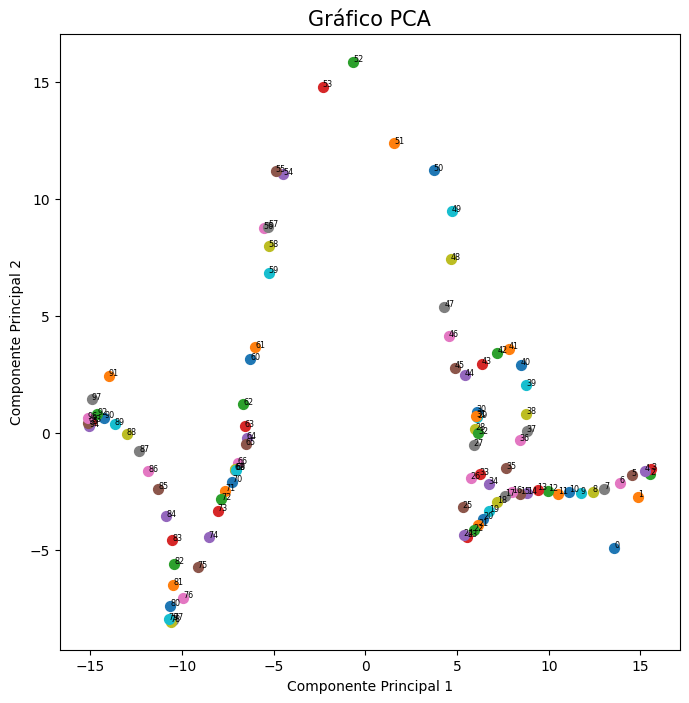

In [76]:
def pca_graph(pca_table):
    plt.figure(figsize = (8,8))
    plt.xlabel("Componente Principal 1", fontsize = 10)
    plt.ylabel("Componente Principal 2", fontsize = 10)
    plt.title("Gráfico PCA", fontsize = 15)

    targets = np.array(pca_table["frame"])
    for t in targets:
        index_line = pca_table.index[pca_table['frame'] == t].tolist()[0]
        x = pca_table['Componente principal 1'][index_line]
        y = pca_table['Componente principal 2'][index_line]
        plt.scatter(x, y, s = 50)
        plt.text(x, y, str(t), fontsize='xx-small')
    plt.show()

pca_graph(all_pca_table)